In [1]:
import numpy as np
from ISLP.models import (ModelSpec as MS,
summarize , poly,Stepwise , sklearn_selected , sklearn_selection_path)
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.api import OLS

import sklearn.model_selection as skm
import sklearn.linear_model as skl
from functools import partial

from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
import statsmodels.formula.api as smf


(a) Create a random number generator and use its normal() method to generate a predictor X of length n = 100, as well as a noise vector ε of length n = 100.

In [2]:
rng = np.random.default_rng(20)
X = rng.normal(size=100,scale=2)
epsilon= rng.normal(size=100)
print(X.max(),X.min())

4.75993478563066 -5.9545290072591825


(b) Generate a response vector Y of length n = 100 according to the model
Y =β0 +β1X+β2X2 +β3X3 +ε, where β0, β1, β2, and β3 are constants of your choice.


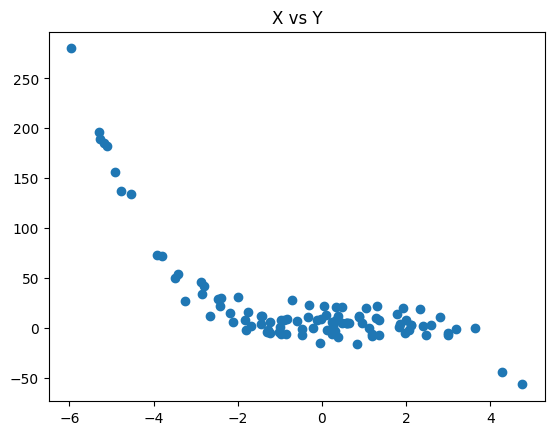

In [3]:
B0= 4
B1= 3
B2= 2
B3=-1
Y= B0 + B1*X + B2*X**2 + B3*X**3 + epsilon*10
plt.scatter(X, Y)
plt.title('X vs Y')
plt.show()
#Pretty! You can vary the influence of the error (increase the sd/scale for epsilon above) to explore when the approach fails!


(c) Use forward stepwise selection in order to select a model containing the predictors X, X2, . . . , X10. What is the model obtained according to Cp? Report the coefficients of the model obtained.


In [4]:
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n
df=pd.DataFrame({f"X^{i}": X**i for i in range(1,11)} )#contracts
design = MS(df.columns).fit(df)#ugly but handy tool from the book
mm=design.transform(df)#making the matrix
results = OLS(Y,mm).fit() #following the book, estimating error variance sigma2 from max model
#print(summarize(results))
sigma2=results.scale
neg_Cp = partial(nCp, sigma2) #We use the function partial() first seen in Section 5.3.3 to freeze the first argument with our estimate of σ2.
#print(sigma2)
strategy = Stepwise.first_peak(design,max_terms=10,direction='forward')
results_Cp = sklearn_selected(OLS, strategy,scoring=neg_Cp)
results_Cp.fit(df, Y)
print(results_Cp.selected_state_)
design2 = MS(['X^1','X^2','X^3','X^4']).fit(df)
mm2=design2.transform(df)#making the matrix
results2 = OLS(Y,mm2).fit()
print(summarize(results2))#bit off due to correlations

('X^2', 'X^3', 'X^5', 'X^7')
             coef  std err       t  P>|t|
intercept  4.2933    1.388   3.092  0.003
X^1        2.5881    0.860   3.009  0.003
X^2        1.1602    0.408   2.843  0.005
X^3       -1.0270    0.063 -16.202  0.000
X^4        0.0258    0.018   1.431  0.156


(d) Repeat (c), using backwards stepwise selection. How does your answer compare to the results in (c)?

In [5]:
strategy = Stepwise.first_peak(design,max_terms=10,direction='backwards')
results_Cp = sklearn_selected(OLS, strategy,scoring=neg_Cp)
results_Cp.fit(df, Y)
print(results_Cp.selected_state_)
design2 = MS(['X^2','X^3','X^5']).fit(df)
mm2=design2.transform(df)#making the matrix
results2 = OLS(Y,mm2).fit()
print(summarize(results2))#way off due to correlations

('X^2', 'X^3', 'X^5', 'X^7')
             coef  std err      t  P>|t|
intercept  3.6935    1.227  3.009  0.003
X^2        1.6230    0.182  8.939  0.000
X^3       -0.6253    0.083 -7.574  0.000
X^5       -0.0126    0.003 -3.915  0.000


(e) Now fit a lasso model to the simulated data, again using X,X2, . . . , X 10 as predictors. Use cross-validation to select the optimal value of λ. Create plots of the cross-validation error as a function of λ. Report the resulting coefficient estimates, and discuss the results obtained.

In [6]:
#first lets define two plots for this
def lassoCVPlot(model,X,Y):
    """
    This will plot for the result of a LassoCV call by plotting the MSE vs lambda values

    Parameters:
    model (result of LassoCV), the (standardized) X data, and response Y 

    Returns:
    A plot, which is also shown. 
    """
    best_lambda = model.alpha_
    lambdas=model.alphas_
    max_iter=model.max_iter
    tol=model.tol
    coefficients = model.coef_
    intercept = model.intercept_
    mean_mse = np.mean(model.mse_path_, axis=1)
    std_mse = np.std(model.mse_path_, axis=1)

    fig=plt.figure(figsize=(8, 5))
    plt.semilogx(lambdas, mean_mse, label='Mean CV MSE',c="k")
    plt.fill_between(model.alphas_,
                 mean_mse - std_mse,
                 mean_mse + std_mse,
                 color='lightblue',
                 alpha=0.5,
                 label='±1 SD')
    plt.axvline(x=best_lambda, linestyle="--",color='r')
    plt.tight_layout()
    plt.draw()
    ax=plt.gca()#get axis object
    if len(lambdas)<10:
        sample=lambdas
    else:
        sample = [lambdas[i] for i in np.linspace(0, len(lambdas) - 1, 10, dtype=int)]

    paths=model.path(df_scaled, Y, alphas=sample,max_iter=max_iter,tol=tol)
    nonzero_counts = np.sum(paths[1] != 0, axis=0) 

    ymin, ymax = ax.get_ylim()
    y_fixed = ymax - 0.05 * (ymax - ymin)

    for x, count in zip(sample, nonzero_counts):
        plt.text(x, y_fixed, str(count),
             ha='center', va='bottom', fontsize=8, rotation=0)
    plt.show()
    return fig

def coefficientValuePlot(model,X,Y):
    """
    This will plot for the result of a LassoCV call coefficient vs lambda values

    Parameters:
    model (result of LassoCV), the (standardized) X data, and response Y 

    Returns:
    A plot, which is also shown. 
    """
    best_lambda = model.alpha_
    lambdas=model.alphas_
    max_iter=model.max_iter
    tol=model.tol
    fig=plt.figure(figsize=(8, 5))
    path=model.path(X, Y, alphas=lambdas,max_iter=max_iter,tol=tol)
    for i in range(model.coef_.shape[0]):
        plt.plot(model.alphas_,path[1][i], label=X.columns[i])
    plt.xscale('log')
    plt.axvline(x=best_lambda, linestyle="--",color='r')
    plt.xlabel('Lambda (log scale)')
    plt.ylabel('Coefficient value')
    plt.title('LassoCV Coefficient Paths')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    return fig

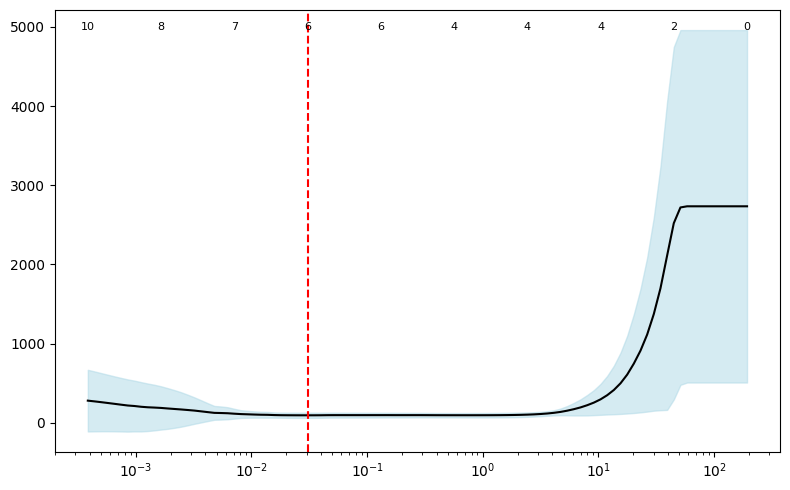

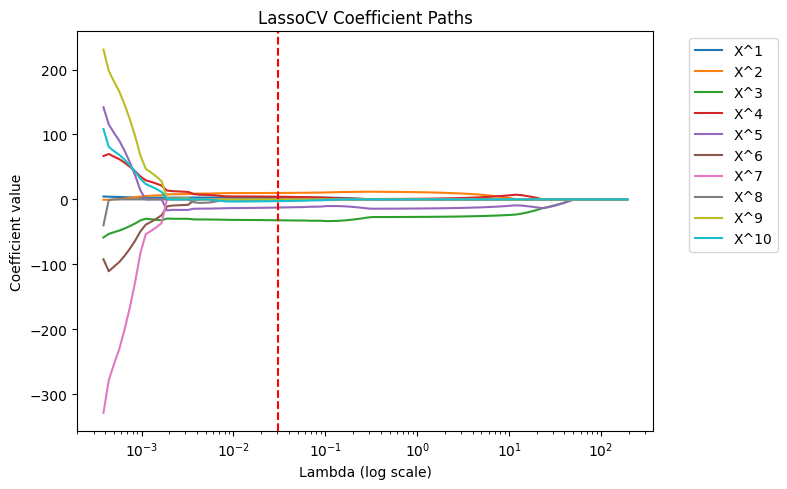

In [7]:
#first we should standardize the data (in the lab a pipeline is set up for this)
scaler = StandardScaler()
scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(scaled, columns=df.columns, index=df.index)
#next define a serie for the meta parameter lambda. You can tune this to sensible values, and avoid errors.
lambdas = 10**np.linspace(4, -1.7, 100) / Y.std()#extending the range to problematic values of lambda gives convergence warnings
#now fit the lasso CV model with the specified lambdas and higher max_iter to help convergence a bit
model = LassoCV(cv=10,alphas=lambdas,max_iter=1000000,tol=1e-4)  # Lasso with 10-fold CV
model.fit(df_scaled, Y)
#plotting
lassoCVPlot(model,df_scaled,Y) #clearly overlearning/variance limits performance for low values of lambda, and overly strict values produce an underfit model
fig=coefficientValuePlot(model,df_scaled,Y) 
#low values of lambda give high values for the coefficients, intermediate give comparable values, high values force all coefficients to 0.



Intercept: 4.140
X^1     1.277071e+00
X^2     1.296574e+00
X^3    -7.390893e-01
X^4     2.014915e-02
X^5    -1.074372e-02
X^6     0.000000e+00
X^7    -0.000000e+00
X^8    -0.000000e+00
X^9     0.000000e+00
X^10   -4.275154e-07
dtype: float64


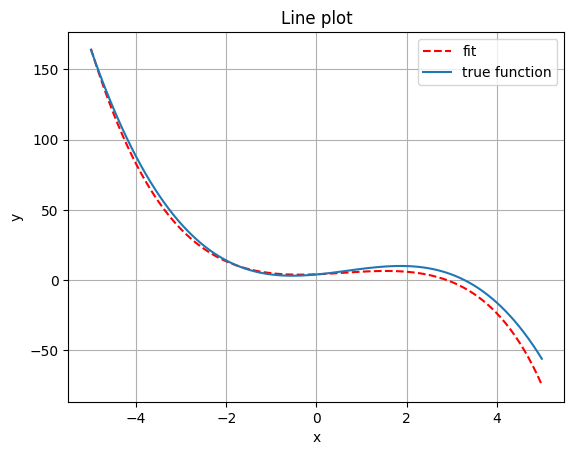

64.41138649918304 329.3363853115061


In [8]:
#now lets have a look at the fitted coefficients
#first convert them back to the original non-standardized scale
coefficients = model.coef_
intercept = model.intercept_
ori_coeff=coefficients/scaler.scale_
ori_coeff=pd.Series(ori_coeff,index=df.columns)
ori_intercept=intercept - (coefficients * scaler.mean_ / scaler.scale_).sum()
print(f"Intercept: {ori_intercept:.3f}")
print(ori_coeff)


#let's see how good of a fit it is
xlin = np.linspace(-5, 5, 100)#this is roughly the observed data range
Xlin=pd.DataFrame({f"X^{i}": xlin**i for i in range(1,11)} )#contracts
ylin=Xlin@ori_coeff+ori_intercept

y_real= B0 + B1*xlin + B2*xlin**2 + B3*xlin**3

plt.plot(xlin, ylin, linestyle='--', color='red',label="fit")
plt.plot(xlin, y_real,label="true function")

plt.xlabel('x')
plt.ylabel('y')
plt.title('Line plot')
plt.grid(True)
plt.legend()
plt.show() # that's a reasonable fit! 
#let's calculate the L1 norms for the fitted line to the actual line coefficients, in the standardized scale
l1_norm_transform = np.sum(np.abs(coefficients))#L1 norm of fit
l1_norm = np.sum(np.abs(np.array([B0,B1,B2,B3])*scaler.scale_[0:4]))#L1 norm of true polynomial in proper scale
print(l1_norm_transform,l1_norm)#aha! Several polynomial functions can approximate our chosen function in this range. Lasso looks for one with a low L1 norm

f) Now generate a response vector Y according to the model $Y = \beta _0 + \beta _7X^7 + \epsilon$,
and perform forward stepwise selection and the lasso. Discuss the results obtained.

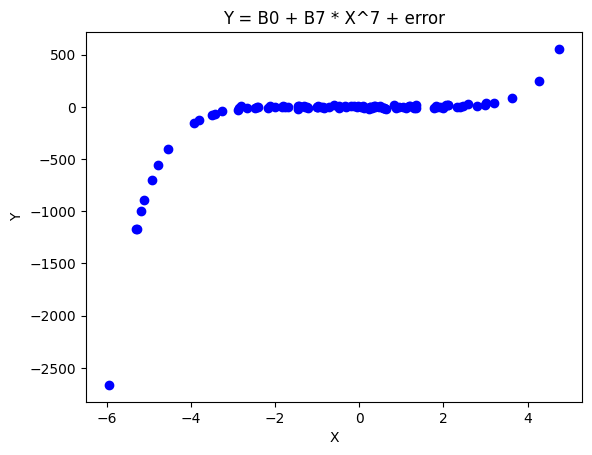

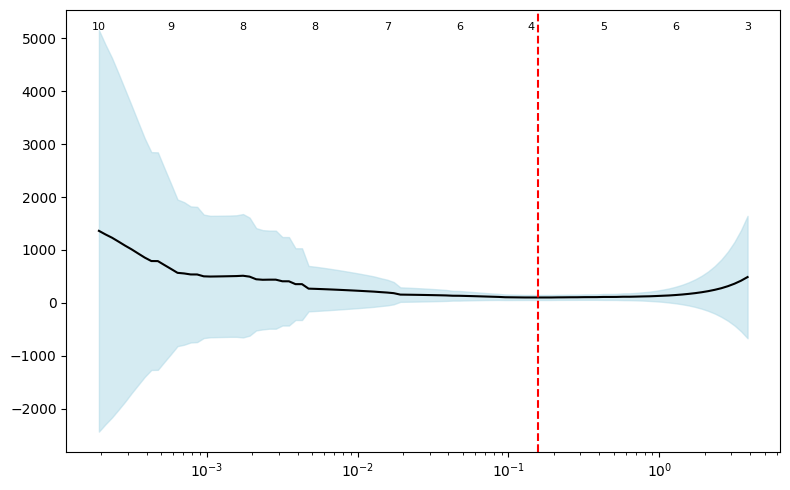

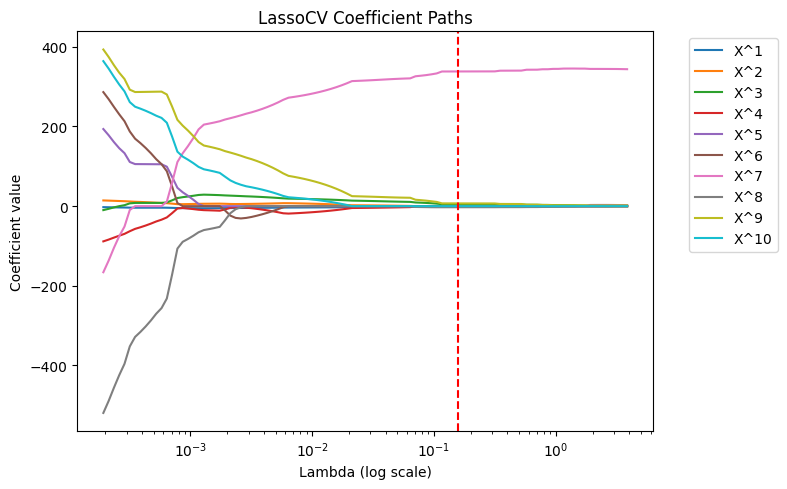

      fittedCoefficients  OriginalScale
X^1            -1.010890      -0.441721
X^2             0.000000       0.000000
X^3             0.000000       0.000000
X^4            -0.000000      -0.000000
X^5            54.713651       0.046681
X^6            -3.133273      -0.000504
X^7           236.796800       0.006754
X^8            -0.000000      -0.000000
X^9            59.920754       0.000054
X^10           -0.000000      -0.000000
0.9875066455970023


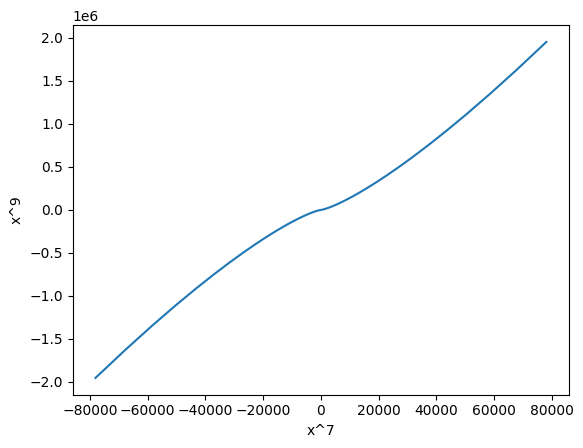

('X^7',)


In [9]:
rng = np.random.default_rng(2)
B0 = 1
B7 = 0.01
Y2 = B0 + B7 * X**7 + rng.normal(size=100,scale=10)

plt.scatter(X, Y2, color='blue')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Y = B0 + B7 * X^7 + error')
plt.show()
lambdas = 10**np.linspace(2.3, -2, 100) / Y.std()#extending the range to problematic values of lambda gives convergence warnings
model2 = LassoCV(cv=10,alphas=lambdas,max_iter=10000000,tol=1e-4)  # Lasso with 10-fold CV
model2.fit(df_scaled, Y2)
lassoCVPlot(model2,df_scaled,Y2) #clearly overlearning/variance limits performance for low values of lambda, and overly strict values produce an underfit model
fig=coefficientValuePlot(model2,df_scaled,Y2) 

best_lambda = model2.alpha_
coefficients = model2.coef_
intercept = model2.intercept_
dfCoeff = pd.DataFrame({'fittedCoefficients': model2.coef_, 'OriginalScale': model2.coef_/scaler.scale_}, index=df_scaled.columns)

print(dfCoeff)#this selects other polynomials as well, probably finding a solution with lower L1 norm than just X^7
#in particular the use of X^9 is likely reducing the L1 norm, as X7 and X9 are correlated, with X9 increasing more rapidly (lower coefficient)
corr = np.corrcoef(df["X^7"], df["X^9"])[0, 1]
print(corr)#0.99!
plt.plot(xlin**7, xlin**9)
plt.xlabel('x^7')
plt.ylabel('x^9')
plt.show() #note the difference in scale! 

strategy = Stepwise.first_peak(design,max_terms=10,direction='forward')
results_Cp = sklearn_selected(OLS, strategy,scoring=neg_Cp)
results_Cp.fit(df, Y2)
print(results_Cp.selected_state_)#the correct result

